# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Project Goals
- What is the probability of receiving and using the offer?
- What are the characteristics of members who used the offer?
- Create a model to determine who is likely to use the offer.

# Section 1: Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

2023-01-05 09:54:06.250281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Section 2: Data Understanding

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [7]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [8]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## 2-1: Portfolio Dataset

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [11]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
portfolio.shape

(10, 6)

In [13]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [14]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [15]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [16]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [17]:
# Rename id column to offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


### Data Cleaning
- Create a data frame that decomposes channels.
- Merge with portfolio data frame.
- Delete the channels column.
- Rename id to offer_id.

In [18]:
df1 = portfolio.copy()

In [19]:
df1_channel = pd.get_dummies(df1['channels'].apply(pd.Series).stack()).sum(level=0)
df1 = pd.concat([df1, df1_channel], axis=1)
df1 = df1.drop(columns='channels')
df1 = df1.rename(columns={'id': 'offer_id'})
df1

/var/folders/h8/6j9fnlsn7bq6gh649_gcjkc80000gn/T/ipykernel_94373/1312292933.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df1_channel = pd.get_dummies(df1['channels'].apply(pd.Series).stack()).sum(level=0)


,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


## 2-2: Profile Dataset

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [20]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [21]:
profile.shape

(17000, 5)

In [22]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [23]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [24]:
profile.duplicated().sum()

0

In [25]:
profile_missing_df = profile[profile['gender'].isnull()]
profile_missing_df.describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


### Data Cleaning
- Changed the type of bename_member_on to datetime.
- Rename id to customer_id.

In [26]:
df2 = profile.copy()

In [27]:
df2 = df2.rename(columns={'id': 'customer_id'})
df2['became_member_on'] = pd.to_datetime(df2['became_member_on'], format='%Y%m%d')
df2

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


## 2-3: Transcript Dataset

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [28]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [29]:
transcript.shape

(306534, 4)

In [30]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [31]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [32]:
transcript['person'].nunique()

17000

In [33]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Data Cleaning
- Rename person to customer_id.
- Create a data frame that decomposes value.
- Merge with transcript data frame.
- Delete the value column.
- Create a data frame that decomposes event.
- Merge with transcript data frame.
- Delete the event column.
- Rename columns.

In [34]:
df3 = transcript.copy()

In [35]:
df3 = df3.rename(columns={'person': 'customer_id'})
df3 = pd.concat([df3, df3['value'].apply(pd.Series)], axis=1)
df3

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN,3.53,NaN,NaN


In [36]:
df3['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df3.value]
df3 = df3.drop(columns={'offer id', 'value'})
df3

,customer_id,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,None,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,None,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,None,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,None,NaN


In [37]:
df3_event = pd.get_dummies(df3['event'])
df3 = pd.concat([df3, df3_event], axis=1)
df3 = df3.drop(columns='event')
df3

,customer_id,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,None,NaN,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,None,NaN,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,3.61,None,NaN,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,None,NaN,0,0,0,1


In [38]:
df3 = df3.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'})
df3.head()

,customer_id,time,amount,offer_id,reward,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


# Section3: Data Preparation

## 3-1:  Merge Datasets
- Merge all datasets.

In [40]:
temp = df3.merge(df2, how='left', on='customer_id')
temp

,customer_id,time,amount,offer_id,reward,offer_completed,offer_received,offer_viewed,transaction,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,F,75,2017-05-09,100000.0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,None,118,2017-08-04,NaN
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,M,68,2018-04-26,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,None,118,2017-09-25,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,None,118,2017-10-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,None,NaN,0,0,0,1,M,66,2018-01-01,47000.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,None,NaN,0,0,0,1,M,52,2018-04-08,62000.0
306531,a00058cf10334a308c68e7631c529907,714,3.61,None,NaN,0,0,0,1,F,63,2013-09-22,52000.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,None,NaN,0,0,0,1,M,57,2016-07-09,40000.0


In [41]:
temp = pd.merge(temp, df1, on='offer_id', how='left')
temp

,customer_id,time,amount,offer_id,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,...,became_member_on,income,reward_y,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,None,...,2017-08-04,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,M,...,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,None,...,2017-09-25,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,None,...,2017-10-02,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,None,NaN,0,0,0,1,M,...,2018-01-01,47000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,None,NaN,0,0,0,1,M,...,2018-04-08,62000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,714,3.61,None,NaN,0,0,0,1,F,...,2013-09-22,52000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,None,NaN,0,0,0,1,M,...,2016-07-09,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
temp.columns

Index(['customer_id', 'time', 'amount', 'offer_id', 'reward_x',
       'offer_completed', 'offer_received', 'offer_viewed', 'transaction',
       'gender', 'age', 'became_member_on', 'income', 'reward_y', 'difficulty',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web'],
      dtype='object')

## 3-2: Data Cleaning
- Categorize offer_id into numbers.
- Delete reward_x columns.

In [45]:
# Check point.
df = temp.copy()

In [46]:
offer_id = df['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', None], dtype=object)

In [47]:
offer_id_dict = pd.Series(offer_id).to_dict()
offer_id_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 2: '2906b810c7d4411798c6938adc9daaa5',
 3: 'fafdcd668e3743c1bb461111dcafc2a4',
 4: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 5: 'f19421c1d4aa40978ebb69ca19b0e20d',
 6: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 7: '3f207df678b143eea3cee63160fa8bed',
 8: 'ae264e3637204a6fb9bb56bc8210ddfd',
 9: '5a8bc65990b245e5a138643cd4eb9837',
 10: None}

In [48]:
offer_id_dict = dict([(value, key) for key, value in offer_id_dict.items()])
offer_id_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
 '2906b810c7d4411798c6938adc9daaa5': 2,
 'fafdcd668e3743c1bb461111dcafc2a4': 3,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 4,
 'f19421c1d4aa40978ebb69ca19b0e20d': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 '3f207df678b143eea3cee63160fa8bed': 7,
 'ae264e3637204a6fb9bb56bc8210ddfd': 8,
 '5a8bc65990b245e5a138643cd4eb9837': 9,
 None: 10}

In [49]:
df['offer_id'] = df['offer_id'].map(offer_id_dict)
df.head()

,customer_id,time,amount,offer_id,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,...,became_member_on,income,reward_y,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,0,NaN,0,1,0,0,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,1,NaN,0,1,0,0,None,...,2017-08-04,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2,NaN,0,1,0,0,M,...,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,3,NaN,0,1,0,0,None,...,2017-09-25,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4,NaN,0,1,0,0,None,...,2017-10-02,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [50]:
df['offer_id'] = df['offer_id'].replace(10, np.nan)
df.head()

,customer_id,time,amount,offer_id,reward_x,offer_completed,offer_received,offer_viewed,transaction,gender,...,became_member_on,income,reward_y,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,0.0,NaN,0,1,0,0,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,1.0,NaN,0,1,0,0,None,...,2017-08-04,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2.0,NaN,0,1,0,0,M,...,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,3.0,NaN,0,1,0,0,None,...,2017-09-25,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4.0,NaN,0,1,0,0,None,...,2017-10-02,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [51]:
df['offer_id'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

In [52]:
df = df.drop(columns={'reward_x'})
df = df.rename(columns={'reward_y': 'reward'})
df.head()

,customer_id,time,amount,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,0.0,0,1,0,0,F,75,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,1.0,0,1,0,0,None,118,2017-08-04,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2.0,0,1,0,0,M,68,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,3.0,0,1,0,0,None,118,2017-09-25,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4.0,0,1,0,0,None,118,2017-10-02,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   time              306534 non-null  int64         
 2   amount            138953 non-null  float64       
 3   offer_id          167581 non-null  float64       
 4   offer_completed   306534 non-null  uint8         
 5   offer_received    306534 non-null  uint8         
 6   offer_viewed      306534 non-null  uint8         
 7   transaction       306534 non-null  uint8         
 8   gender            272762 non-null  object        
 9   age               306534 non-null  int64         
 10  became_member_on  306534 non-null  datetime64[ns]
 11  income            272762 non-null  float64       
 12  reward            167581 non-null  float64       
 13  difficulty        167581 non-null  float64       
 14  dura

## 3-3: Data Visualization
- Gender distribution.
- Age distribution.
- Age and gender distribution.
- Income distribution.
- Income and gender distribution.
- Classification by offer type.
- Classification by offer id.
- Became_member_on distribution.

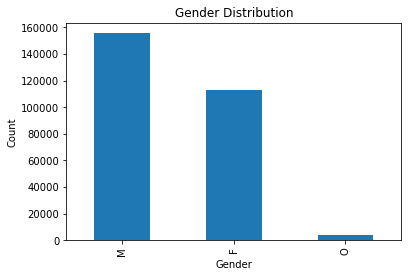

In [54]:
df_gender = df['gender'].value_counts()
df_gender.plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

In [55]:
df['gender'].value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

### Observation
- There are more male users.

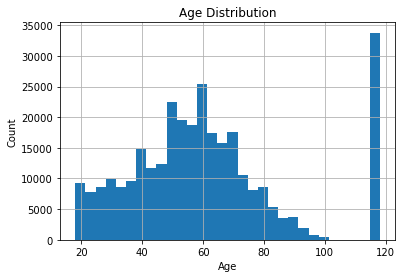

In [56]:
df['age'].hist(bins=30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

In [57]:
df['age'].describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

### Observation
- The 118 year olds are considered to be best ignored.
- The clientele is mostly in their 50s and 60s.

/Users/shonakamura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/shonakamura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


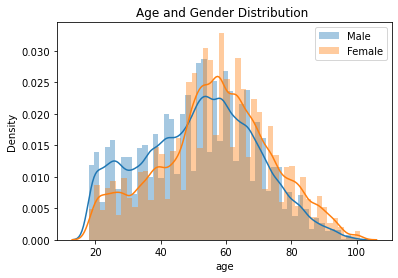

In [58]:
sns.distplot(df[df['gender'] == 'M']['age'], label='Male')
sns.distplot(df[df['gender'] == 'F']['age'], label='Female')
plt.title('Age and Gender Distribution ')
plt.legend()
plt.show()

### Observation
- Younger generations are more likely to be male.

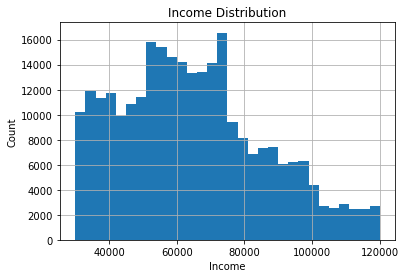

In [59]:
df['income'].hist(bins=30)
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Income Distribution')
plt.show()

In [60]:
df['income'].describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

### Observation
- About 60000 is the average.
- Utilization drops off after 80000.

/Users/shonakamura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/shonakamura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


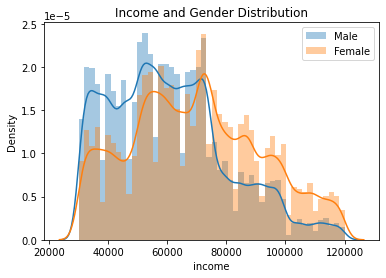

In [61]:
sns.distplot(df[df['gender'] == 'M']['income'], label='Male')
sns.distplot(df[df['gender'] == 'F']['income'], label='Female')
plt.title('Income and Gender Distribution')
plt.legend()
plt.show()

- Women appear to have higher incomes.

Text(0.5, 1.0, 'Type Offer Received Classification')

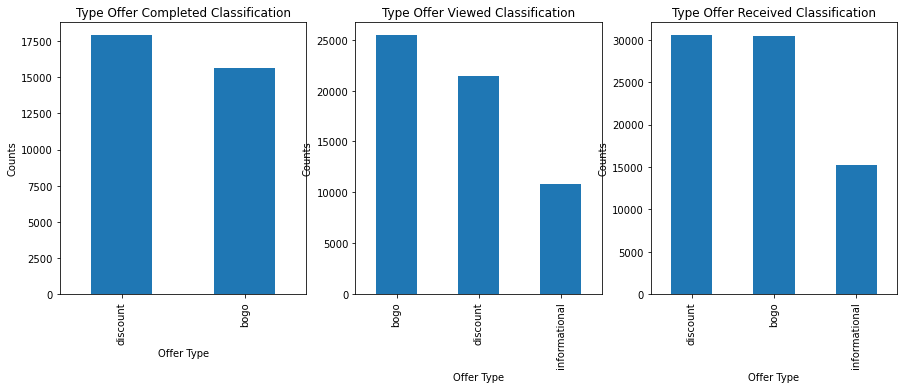

In [62]:
plt.subplot(131)
offer_completed = df[df['offer_completed'] == 1]['offer_type'].value_counts()
offer_completed.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Offer Type')
plt.ylabel('Counts')
plt.title('Type Offer Completed Classification')

plt.subplot(132)
offer_viewed = df[df['offer_viewed'] == 1]['offer_type'].value_counts()
offer_viewed.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Offer Type')
plt.ylabel('Counts')
plt.title('Type Offer Viewed Classification')

plt.subplot(133)
offer_received = df[df['offer_received'] == 1]['offer_type'].value_counts()
offer_received.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Offer Type')
plt.ylabel('Counts')
plt.title('Type Offer Received Classification')

In [63]:
# Discount offer
# Probability of receiving and seeing the offer
print("Probability of receiving and seeing the offer: {}".format(offer_viewed[1]/offer_received[0]))

# Probability of receiving and using the offer
print("Probability of receiving and using the offer: {}".format(offer_completed[0]/offer_received[0]))

Probability of receiving and seeing the offer: 0.702124873129686
Probability of receiving and using the offer: 0.5863864060504862


In [64]:
# Bogo offer
# Probability of receiving and seeing the offer
print("Probability of receiving and seeing the offer: {}".format(offer_viewed[0]/offer_received[1]))

# Probability of receiving and using the offer
print("Probability of receiving and using the offer: {}".format(offer_completed[1]/offer_received[1]))

Probability of receiving and seeing the offer: 0.8344208006819895
Probability of receiving and using the offer: 0.5137545493294862


### Observation
- More than half of those who receive offers review the content.
- Both Discount and Bogo are used by more than 70% of those who received offers.
- Bogo's offer has a higher utilization rate.
- It seems that as long as they open the email, they will use it.

In [65]:
offer_received = df[df['offer_received'] == 1]['offer_id'].value_counts().sort_index()

Text(0.5, 1.0, 'Classification by Offer Id in Offer Received')

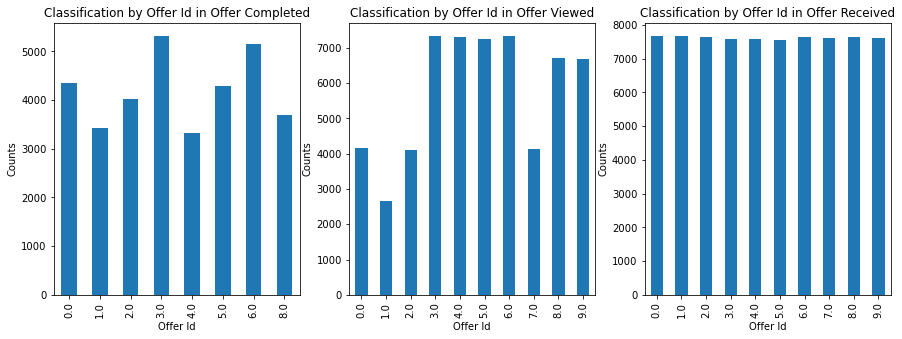

In [66]:
plt.subplot(131)
offer_completed = df[df['offer_completed'] == 1]['offer_id'].value_counts().sort_index()
offer_completed.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Offer Id')
plt.ylabel('Counts')
plt.title('Classification by Offer Id in Offer Completed')

plt.subplot(132)
offer_viewed = df[df['offer_viewed'] == 1]['offer_id'].value_counts().sort_index()
offer_viewed.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Offer Id')
plt.ylabel('Counts')
plt.title('Classification by Offer Id in Offer Viewed')

plt.subplot(133)
offer_received = df[df['offer_received'] == 1]['offer_id'].value_counts().sort_index()
offer_received.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Offer Id')
plt.ylabel('Counts')
plt.title('Classification by Offer Id in Offer Received')

### Observation
- All offer IDs received approximately the same number of offers.
- Those with offer IDs of 3 and 6 have high usage rates. The probability that they are both looking at the offer is also high.
- The offer Id's 3-6 and 8 and 9 have a high probability of having their offers confirmed, yet their usage rates are varied.
- Offer IDs 7 and 9 have never been used.

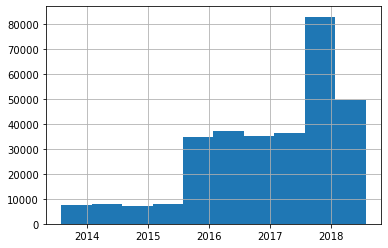

In [67]:
df['became_member_on'].hist();

In [68]:
print(df['became_member_on'].min())
print(df['became_member_on'].max())

2013-07-29 00:00:00
2018-07-26 00:00:00


### Observation
- Membership seems to have increased around 2016.

## 3-4: Additional data clean
- From the date of membership, quantify the number of days since membership.
- Decompose the gender column.
- Decompose the offer type.

In [69]:
df['membership_days'] = (df['became_member_on'].max()- df['became_member_on']).dt.days
df = df.drop(columns='became_member_on')

In [70]:
df_gender = pd.get_dummies(df['gender'])
df = pd.concat([df, df_gender], axis=1)
df = df.drop(columns='gender')
df = df.rename(columns={'M': 'gender_M', 'F': 'gender_F', 'O': 'gender_O'})
df

,customer_id,time,amount,offer_id,offer_completed,offer_received,offer_viewed,transaction,age,income,...,duration,offer_type,email,mobile,social,web,membership_days,gender_F,gender_M,gender_O
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,0.0,0,1,0,0,75,100000.0,...,7.0,bogo,1.0,1.0,0.0,1.0,443,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,1.0,0,1,0,0,118,NaN,...,10.0,discount,1.0,0.0,0.0,1.0,356,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2.0,0,1,0,0,68,70000.0,...,7.0,discount,1.0,1.0,0.0,1.0,91,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,3.0,0,1,0,0,118,NaN,...,10.0,discount,1.0,1.0,1.0,1.0,304,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4.0,0,1,0,0,118,NaN,...,5.0,bogo,1.0,1.0,1.0,1.0,297,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,NaN,0,0,0,1,66,47000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,206,0,1,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,NaN,0,0,0,1,52,62000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,109,0,1,0
306531,a00058cf10334a308c68e7631c529907,714,3.61,NaN,0,0,0,1,63,52000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1768,1,0,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,NaN,0,0,0,1,57,40000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,747,0,1,0


In [71]:
df_offer_type = pd.get_dummies(df['offer_type'])
df = pd.concat([df, df_offer_type], axis=1)
df = df.drop(columns='offer_type')
df

,customer_id,time,amount,offer_id,offer_completed,offer_received,offer_viewed,transaction,age,income,...,mobile,social,web,membership_days,gender_F,gender_M,gender_O,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,0.0,0,1,0,0,75,100000.0,...,1.0,0.0,1.0,443,1,0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,1.0,0,1,0,0,118,NaN,...,0.0,0.0,1.0,356,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2.0,0,1,0,0,68,70000.0,...,1.0,0.0,1.0,91,0,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,3.0,0,1,0,0,118,NaN,...,1.0,1.0,1.0,304,0,0,0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4.0,0,1,0,0,118,NaN,...,1.0,1.0,1.0,297,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,NaN,0,0,0,1,66,47000.0,...,NaN,NaN,NaN,206,0,1,0,0,0,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,NaN,0,0,0,1,52,62000.0,...,NaN,NaN,NaN,109,0,1,0,0,0,0
306531,a00058cf10334a308c68e7631c529907,714,3.61,NaN,0,0,0,1,63,52000.0,...,NaN,NaN,NaN,1768,1,0,0,0,0,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,NaN,0,0,0,1,57,40000.0,...,NaN,NaN,NaN,747,0,1,0,0,0,0


In [97]:
# Check point
df_temp = df
df_temp.columns

Index(['customer_id', 'time', 'amount', 'offer_id', 'offer_completed',
       'offer_received', 'offer_viewed', 'transaction', 'age', 'income',
       'reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web',
       'membership_days', 'gender_F', 'gender_M', 'gender_O', 'bogo',
       'discount', 'informational'],
      dtype='object')

In [98]:
df.isnull().sum()

customer_id             0
time                    0
amount             167581
offer_id           138953
offer_completed         0
offer_received          0
offer_viewed            0
transaction             0
age                     0
income              33772
reward             138953
difficulty         138953
duration           138953
email              138953
mobile             138953
social             138953
web                138953
membership_days         0
gender_F                0
gender_M                0
gender_O                0
bogo                    0
discount                0
informational           0
dtype: int64

In [99]:
df.shape

(306534, 24)

- Even if all the rows with missing values are deleted, there is still about 130,000 data to delete.
- Since time and membership days are similar, remove time this time.

In [100]:
# By deleting the missing income values, the data with an age of 118 can be deleted at the same time.
df_temp = df_temp.dropna(subset=['income'])
df_temp = df_temp.dropna(subset=['reward'])
df_temp = df_temp.drop(columns='amount')

# Create a model to predict who used the offer.
X = df_temp.drop(['customer_id','offer_completed','offer_received', 'offer_viewed', 'transaction', 'time'], axis=1)
Y = df_temp['offer_completed']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

std = StandardScaler()

# Standardization X_train
X_train['income'] = std.fit_transform(X_train['income'].values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train['age'].values.reshape(-1, 1))
X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

# Standardization X_test
X_test['income'] = std.fit_transform(X_test['income'].values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test['age'].values.reshape(-1, 1))
X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# RandomForest
model = RandomForestClassifier()
model.fit(X_train, y_train)
train = model.predict(X_train)
train_score = accuracy_score(y_train, train)
test = model.predict(X_test)
test_score = accuracy_score(y_test, test)
print(f"train_score:{train_score}")
print(f"test_score：{test_score}")

train_score:0.8041147048376103
test_score：0.6576318265310694


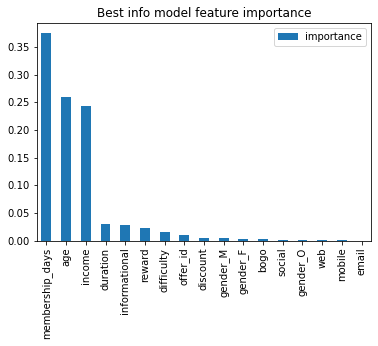

In [83]:
importances = model.feature_importances_

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                  columns=['importance']).sort_values('importance',ascending=False)

feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

## Observation
- It is clear that those who have been members for longer periods of time use the offer more.
- The score is not very good.

# Section 5: Improving Prediction Model

## 5-1: Changed the model to Keras.
- For binary classification, the activation function is sigmoid.

In [112]:
# Same data set as Section4
df_temp = df
df_temp = df_temp.dropna(subset=['income'])
df_temp = df_temp.dropna(subset=['reward'])
df_temp = df_temp.drop(columns='amount')

X = df_temp.drop(['customer_id','offer_completed','offer_received', 'offer_viewed', 'transaction', 'time'], axis=1)
Y = df_temp['offer_completed']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

std = StandardScaler()

X_train['income'] = std.fit_transform(X_train['income'].values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train['age'].values.reshape(-1, 1))
X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

X_test['income'] = std.fit_transform(X_test['income'].values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test['age'].values.reshape(-1, 1))
X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


# Keras
model = keras.models.Sequential()

model.add(keras.layers.Dense(6, activation='relu'))
model.add(keras.layers.Dense(6, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)

Epoch 1/15
1042/1042 [==============================] - 2s 1ms/step - loss: 0.5322 - accuracy: 0.7710 - val_loss: 0.5022 - val_accuracy: 0.7819
Epoch 2/15
1042/1042 [==============================] - 1s 1ms/step - loss: 0.4997 - accuracy: 0.7803 - val_loss: 0.4935 - val_accuracy: 0.7820
Epoch 3/15
1042/1042 [==============================] - 1s 1ms/step - loss: 0.4938 - accuracy: 0.7802 - val_loss: 0.4879 - val_accuracy: 0.7820
Epoch 4/15
1042/1042 [==============================] - 1s 1ms/step - loss: 0.4901 - accuracy: 0.7803 - val_loss: 0.4860 - val_accuracy: 0.7818
Epoch 5/15
1042/1042 [==============================] - 1s 1ms/step - loss: 0.4866 - accuracy: 0.7804 - val_loss: 0.4812 - val_accuracy: 0.7820
Epoch 6/15
1042/1042 [==============================] - 1s 1ms/step - loss: 0.4829 - accuracy: 0.7808 - val_loss: 0.4796 - val_accuracy: 0.7820
Epoch 7/15
1042/1042 [==============================] - 1s 1ms/step - loss: 0.4820 - accuracy: 0.7802 - val_loss: 0.4809 - val_accuracy:

In [113]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 108       
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
 dense_8 (Dense)             (None, 1)                 7         
                                                                 
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.evaluate(X_test , y_test)

1396/1396 [==============================] - 1s 766us/step - loss: 0.4752 - accuracy: 0.7820


[0.47522708773612976, 0.7819766402244568]

In [114]:
model.evaluate(X_train, y_train)

3256/3256 [==============================] - 2s 747us/step - loss: 0.4742 - accuracy: 0.7820


[0.47418537735939026, 0.7819667458534241]

### Observation
- The accuracy has increased by more than 10% since RandomForest.

## 5-2: Leave the model in Keras and try to increase the number of data without removing missing values.

In [116]:
df_temp = df
df.isnull().sum()

customer_id             0
time                    0
amount             167581
offer_id           138953
offer_completed         0
offer_received          0
offer_viewed            0
transaction             0
age                     0
income              33772
reward             138953
difficulty         138953
duration           138953
email              138953
mobile             138953
social             138953
web                138953
membership_days         0
gender_F                0
gender_M                0
gender_O                0
bogo                    0
discount                0
informational           0
dtype: int64

In [117]:
X = df_temp.drop(['customer_id','offer_completed','offer_received', 'offer_viewed', 'transaction', 'time'], axis=1)
Y = df_temp['offer_completed']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

std = StandardScaler()

X_train['income'] = std.fit_transform(X_train['income'].values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train['age'].values.reshape(-1, 1))
X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

X_test['income'] = std.fit_transform(X_test['income'].values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test['age'].values.reshape(-1, 1))
X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

model = keras.models.Sequential()

model.add(keras.layers.Dense(6, activation='relu'))
model.add(keras.layers.Dense(6, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)

Epoch 1/15
2146/2146 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.8909 - val_loss: nan - val_accuracy: 0.8894
Epoch 2/15
2146/2146 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.8909 - val_loss: nan - val_accuracy: 0.8894
Epoch 3/15
2146/2146 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.8909 - val_loss: nan - val_accuracy: 0.8894
Epoch 4/15
2146/2146 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.8909 - val_loss: nan - val_accuracy: 0.8894
Epoch 5/15
2146/2146 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.8909 - val_loss: nan - val_accuracy: 0.8894
Epoch 6/15
2146/2146 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.8909 - val_loss: nan - val_accuracy: 0.8894
Epoch 7/15
2146/2146 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.8909 - val_loss: nan - val_accuracy: 0.8894
Epoch 8/15
2146/2146 [============

In [118]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6)                 114       
                                                                 
 dense_10 (Dense)            (None, 6)                 42        
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.evaluate(X_test , y_test)

2874/2874 [==============================] - 2s 733us/step - loss: nan - accuracy: 0.8894


[nan, 0.8893987536430359]

In [120]:
model.evaluate(X_train, y_train)

6706/6706 [==============================] - 5s 749us/step - loss: nan - accuracy: 0.8909


[nan, 0.8909088969230652]

In [101]:
com = pd.DataFrame(np.arange(6).reshape(2, 3),
                        columns=['RandomForest', 'case1', 'case2'],
                        index=['train_score', 'test_score'])
com

,RandomForest,case1,case2
train_score,0,1,2
test_score,3,4,5


In [127]:
com['RandomForest'][0] = 0.8041147048376103*100 
com['RandomForest'][1] = 0.6576318265310694*100

com['case1'][0] = 0.7819667458534241*100
com['case1'][1] = 0.7819766402244568*100

com['case2'][0] = 0.8909088969230652*100
com['case2'][1] = 0.8893987536430359*100

com

,RandomForest,case1,case2
train_score,80,78,89
test_score,65,78,88


## Observation
- This is an increase of more than 10% compared to earlier.
- More than 20% improvement over the first RandomForest.
- We thought that 130,000 data points would be enough, but perhaps not enough.

# Section 6: Conclusion

### What is the probability of receiving and using the offer?
- The probability of receiving and using an offer was 51% for Bogo offers and 58% for Discount offers.

### What are the characteristics of members who used the offer?
- Number of days in membership, then age and income.

### Create a model to determine who is likely to use the offer.
- The model was better using Keras than using RandomForest.

### Impressions
- I thought the model using DeepLearning seemed to score higher.
- The transcipt.json process was the trickiest.